## Introduction  
In this lab, we would like to make an XGBoost model to study the e-commerce behavior from a multi-category store. First, we need to download the data to your local machine, then we will load the data into a Pandas DataFrame.

## Objectives
- Apply XGBoost to an example

## Instruction
* Accept the Kaggle policy and download the data from [Kaggle](https://www.kaggle.com/code/tshephisho/ecommerce-behaviour-using-xgboost/data)
* For the first model you will only use the 2019-Nov csv data (which is still around ~2gb zipped)

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime

In [2]:
# fill this in with your path (absolute path works as well)
path_to_file = "2019-Nov.csv"
df = pd.read_csv(path_to_file)

Start with some exploratory analysis. First, take a look at the first five rows of the DataFrame. Then get the information about the DataFrame, what is the shape of the DataFrame, and what are the coumn names?

In [3]:
# your code
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
# your code
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [5]:
# your code
df.shape

(67501979, 9)

In [6]:
# your code
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

# Know your Customers
How many unique customers visit the site? Assign the number of visitors to the visitor variable and print it out

In [7]:
# your code
visitor = df['user_id'].nunique()
print(visitor)

3696117


# Visitors Daily Trend
Does traffic fluctuate by date? Try using the `event_time` and `user_id` to see traffic. First you need to select by `event_time` and `user_id`, then you will `drop_duplicates` and `groupby` `event_time` and `user_id`.

In [8]:
d = df.loc[:, ["event_time", "user_id"]]
d["event_time"] = d["event_time"].apply(lambda s: str(s)[0:10])
visitor_by_date = (
    d.drop_duplicates()
    .groupby(["event_time"])["user_id"]
    .agg(["count"])
    .sort_values(by=["event_time"], ascending=True)
)
x = pd.Series(visitor_by_date.index.values).apply(
    lambda s: datetime.strptime(s, "%Y-%m-%d").date()
)
y = visitor_by_date["count"]

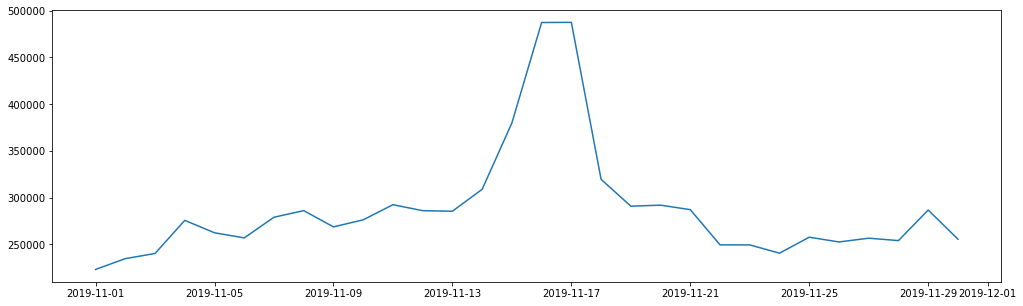

In [9]:
plt.rcParams["figure.figsize"] = (17, 5)
plt.plot(x, y)
plt.show()

### By Category and Product
Which category do customers interact with the most? What brand do they view the most? You can choose just the categories with at least 30 records in order to construct the plots.

In [10]:
max_category_num = 30
top_category = (
    df.loc[:, "category_code"]
    .value_counts()[:max_category_num]
    .sort_values(ascending=False)
)

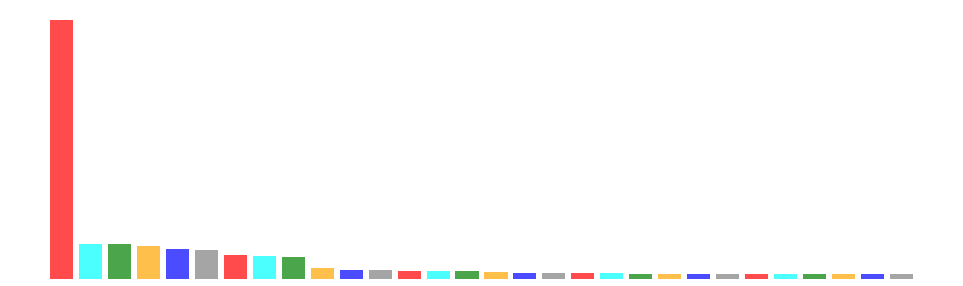

In [11]:
plt.bar(
    height=top_category,
    x=top_category.index.array,
    color=["red", "cyan", "green", "orange", "blue", "grey"],
    alpha=0.7,
)
plt.axis("off")
plt.show()

## Purchases

When the event_type is "purchase", what item do customers buy?

Try using `'event_type' == 'purchase'` and drop empty rows to assess which categories customers buy.

In [12]:
# your code
purchase = df[df['event_type'] == 'purchase'].dropna(axis=0)
purchase['category_id'].value_counts()

2053013555631882655    382492
2053013554658804075     40742
2053013554415534427     30098
2053013563810775923     19680
2053013558920217191     18175
                        ...  
2187707789055361298         1
2053013560581161671         1
2078957461947024180         1
2053013555782877609         1
2163334577303585455         1
Name: category_id, Length: 240, dtype: int64

## What brands do the customers buy?
Try grouping by brand and sorting the values by the brand name.

In [13]:
# your code
brands = df.groupby('brand')['brand'].agg(['count']).sort_values('brand')
brands.head()

,count
brand,
a-case,12647
a-derma,431
a-elita,320
a-mega,833
aardwolf,478


In [14]:
del d  # free memory

# Modeling: predict at the time of addition to a shopping cart if the user will purchase a given product or not

### Feature engineering

The goal of this modeling is to predict if the user will purchase a product or not when they add the product to the cart. This is called `cart abandonment` if the user does not purchase.

First, reconstruct and restructure the data to feed into the machine learning model. For this use case, target only the data for which customers have "put" the product into the cart. The relevant `event_type`s are thus "cart" and "purchase".

Create these new features in the training data set:
- `activity_count`: number of activity in that session
- `category_level1`: category
- `category_level2`: sub-category --> split on the "." in the category name
- `weekday`: weekday of the event --> convert `event_time` to a datetime object, then use `pandas.Timestamp.weekday`
- `is_purchased`: whether the is purchased after being put in the cart, this will be the categorical output.

Make sure to de-dup any record.

**Prepare a dataframe for counting activity in the session**

In [15]:
# your code
# first just eliminate the records where event_type = "view" and drop NA values and duplicates
data = df[df['event_type'] != 'view'].dropna(axis=0).drop_duplicates()

In [16]:
# now you get the number of activities by user session

activity_in_session = (
    data.groupby(["user_session"])["event_type"]
    .count()
    .reset_index()
)
activity_in_session = activity_in_session.rename(
    columns={"event_type": "activity_count"}
)
df_targets = data.copy()

In [17]:
# create the two new columns for the category levels 1 and 2
# your code here
df_targets['category_l1'] = df_targets['category_code'].str.split('.', expand=True)[0].astype('category')
df_targets['category_l2'] = df_targets['category_code'].str.split('.', expand=True)[1].astype('category')

In [18]:
# Change the event_time to a timestamp
# your code
df_targets['event_time'] = pd.to_datetime(df_targets['event_time'])

In [19]:
# Use pandas.dt.dayofweek to get the day of the week
# your code
df_targets['weekday'] = df_targets['event_time'].dt.dayofweek

In [20]:
# add the is_purchased feature
# your code
df_targets['is_purchased'] = (df_targets['event_type'] == 'purchase')

In [21]:
df_targets = df_targets.merge(activity_in_session, on="user_session", how="left")
df_targets["activity_count"] = df_targets["activity_count"].fillna(0)
df_targets["brand"] = df_targets["brand"].astype("category")
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_l1,category_l2,weekday,is_purchased,activity_count
0,2019-11-01 00:00:14+00:00,cart,1005014,2053013555631882655,electronics.smartphone,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,electronics,smartphone,4,False,1
1,2019-11-01 00:01:04+00:00,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d,electronics,smartphone,4,True,1
2,2019-11-01 00:03:24+00:00,cart,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e,electronics,video,4,False,14
3,2019-11-01 00:03:39+00:00,cart,1005115,2053013555631882655,electronics.smartphone,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,electronics,smartphone,4,False,1
4,2019-11-01 00:04:51+00:00,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,562958505,0f039697-fedc-40fa-8830-39c1a024351d,electronics,smartphone,4,True,1


### Save new data structure if desired

In [22]:
df_targets.to_csv('training_data.csv')

In [23]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2704549 entries, 0 to 2704548
Data columns (total 14 columns):
 #   Column          Dtype              
---  ------          -----              
 0   event_time      datetime64[ns, UTC]
 1   event_type      object             
 2   product_id      int64              
 3   category_id     int64              
 4   category_code   object             
 5   brand           category           
 6   price           float64            
 7   user_id         int64              
 8   user_session    object             
 9   category_l1     category           
 10  category_l2     category           
 11  weekday         int64              
 12  is_purchased    bool               
 13  activity_count  int64              
dtypes: bool(1), category(3), datetime64[ns, UTC](1), float64(1), int64(5), object(3)
memory usage: 239.9+ MB


In [24]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

## Resampling training set

In [25]:
is_purcahase_set = df_targets[df_targets["is_purchased"] == 1]
is_purcahase_set.shape[0]

659251

In [26]:
not_purcahase_set = df_targets[df_targets["is_purchased"] == 0]
not_purcahase_set.shape[0]

2045298

In [27]:
n_samples = 500000
is_purchase_downsampled = resample(
    is_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)
not_purcahase_set_downsampled = resample(
    not_purcahase_set, replace=False, n_samples=n_samples, random_state=27
)

In [28]:
downsampled = pd.concat([is_purchase_downsampled, not_purcahase_set_downsampled])
downsampled["is_purchased"].value_counts()

True     500000
False    500000
Name: is_purchased, dtype: int64

In [29]:
# select the brand, price, weekday, category_level1, cateogry_level2, and activity_count features

features = downsampled[['brand', 'price', 'weekday', 'category_l1', 'category_l2', 'activity_count']]

## Encode categorical variables

In [31]:
features.loc[:, "brand"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "brand"].copy()
)
features.loc[:, "weekday"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "weekday"].copy()
)
features.loc[:, "category_l1"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_l1"].copy()
)
features.loc[:, "category_l2"] = LabelEncoder().fit_transform(
    downsampled.loc[:, "category_l2"].copy()
)

is_purchased = LabelEncoder().fit_transform(downsampled["is_purchased"])
features.head()

,brand,price,weekday,category_l1,category_l2,activity_count
2358531,73,1002.90,1,7,40,2
2457359,84,152.72,2,7,55,2
1458408,1038,540.53,6,7,55,5
39519,73,458.25,5,7,40,3
1549305,1175,123.53,6,2,18,3


In [32]:
print(list(features.columns))

['brand', 'price', 'weekday', 'category_l1', 'category_l2', 'activity_count']


## Split the data
Use a test size of 0.3 and a random state of 86 to split the data into test and train subsets

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features, is_purchased, test_size=0.3, random_state=86)

## Train the model
Choose learning rate of 0.1 on XGBClassifier, fit the model, and make predictions on the test set

In [34]:
from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.1)
# fit the model on the train sets

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [35]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("fbeta:", metrics.fbeta_score(y_test, y_pred, average="weighted", beta=0.5))

Accuracy: 0.6415933333333333
Precision: 0.6239219114219114
Recall: 0.7135193133047211
fbeta: 0.6418009650619528


## Feature importance
Plot the feature importance using plot_importance

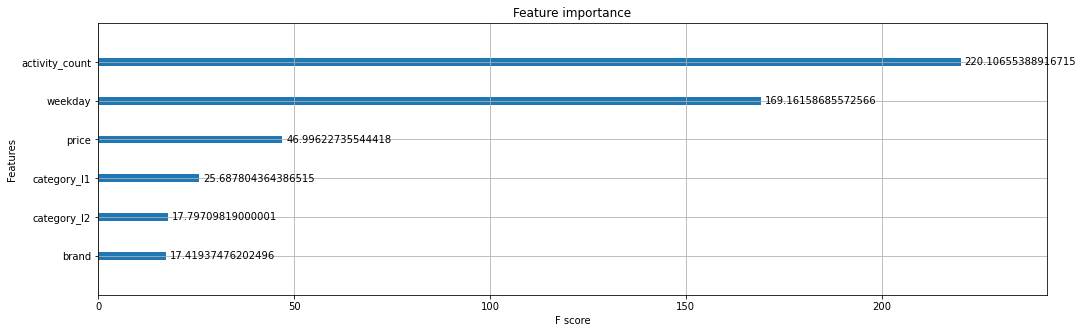

In [36]:
plot_importance(model, max_num_features=10, importance_type="gain")
# plt.rcParams['figure.figsize'] = (40,10)
plt.show()